In [24]:
#Libraries
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from matplotlib.cm import get_cmap

In [25]:
df = pd.read_excel(r"C:\Users\nunez\OneDrive\Escritorio\Bases\base_2012_2022_limpia.xlsx")
#MacOS
#df = pd.read_excel("/Users/santi/Desktop/Work/Bases/base_2012_2022_limpia.xlsx")

#Select 2022
#df = df[df["ANIO"] != 2022]

#Geojson barrios caba
GeoJson_barrios = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson"
geojson = gpd.read_file(GeoJson_barrios)

#Point geometries from lat, long columns
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy( df["Longitud"], df["Latitud"]))

#Boundary of CABA
boundary = unary_union(geojson["geometry"]).exterior

#Removing al points outside of the boundary

# perform spatial join
joined = gpd.sjoin(gdf, geojson, op='within')

# filter out points that do not intersect with the boundary
points_within_boundary = joined[joined.index_right.notnull()]

points_within_boundary["TIPO_OBRA"] = points_within_boundary["TIPO_OBRA"].astype(str)
points_within_boundary = points_within_boundary[points_within_boundary["TIPO_OBRA"] == '1']

clean_df = points_within_boundary

C:\Users\nunez\PycharmProjects\Permisos_de_obra\venv\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\nunez\AppData\Local\Temp\ipykernel_8440\825660394.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined = gpd.sjoin(gdf, geojson, op='within')


for i in points_within_boundary["USO_1"].unique():
    fig, ax = plt.subplots()
    geojson["geometry"].plot(ax=ax, color='lightgrey')
    points_within_boundary[points_within_boundary["USO_1"] == i].plot(ax=ax, markersize=2)
    ax.set_title(f"Uso: {i}")
    plt.show()

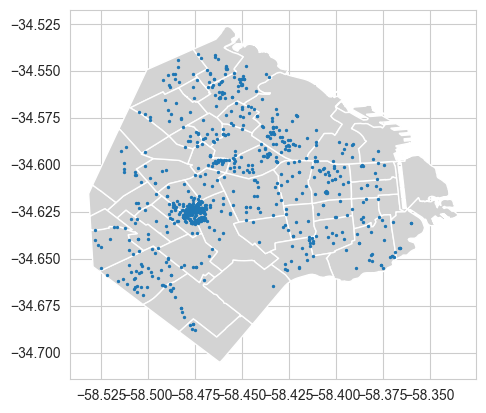

In [26]:
fig, ax = plt.subplots()
geojson["geometry"].plot(ax=ax, color='lightgrey')
points_within_boundary[points_within_boundary["USO_1"] == 'LOCAL COMERCIAL'].plot(ax=ax, markersize=2)
#points_within_boundary.plot(ax=ax, markersize=2)

plt.show()

In [32]:
clean_df = clean_df[clean_df["TIPO_OBRA"] == '1']
clean_df = clean_df[clean_df["USO_1"] == "LOCAL COMERCIAL"]
clean_df.drop_duplicates(subset="geometry", keep='first', inplace=True, ignore_index=False)

points_in_radians = clean_df[['Latitud','Longitud']].apply(np.radians).values

distances = haversine_distances(points_in_radians) * 6371

dbscan = DBSCAN(eps=0.2, min_samples=5, metric='precomputed')
labels = dbscan.fit_predict(distances)

# Add the cluster labels to the dataframe
clean_df['cluster'] = labels
df_clusters = clean_df[clean_df["cluster"] != -1]

<Axes: >

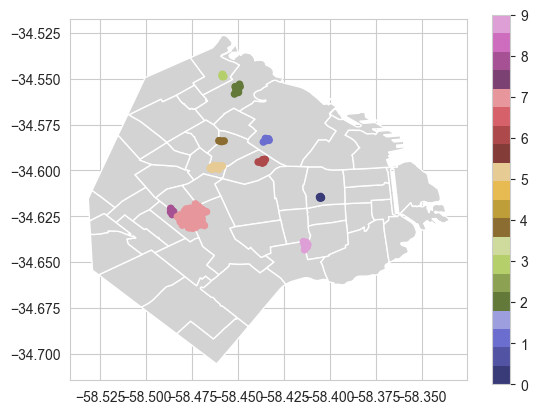

In [33]:
fig, ax = plt.subplots()
geojson["geometry"].plot(ax=ax, color='lightgrey')
clean_df[clean_df["cluster"] != -1].plot(column="cluster", ax=ax, markersize=20, legend=True, cmap='tab20b')

In [35]:
import folium
m = folium.Map(location=[-34.6, -58.4])
list = ['red', 'darkred', 'green', 'purple', 'white', 'cadetblue', 'darkpurple', 'pink', 'darkgreen', 'gray', 'lightgray', 'blue', 'lightred', 'lightgreen', 'beige', 'black', 'lightblue', 'orange', "darkblue"]

for index, row in df_clusters.iterrows():
    folium.Marker(location=[row["Latitud"], row["Longitud"]],popup=f"Cluster {row['USO_1']}" ,icon=folium.Icon(color=list[row["cluster"]])).add_to(m)
m.save("clusters_comerciales_2012_2022.html")